**Initial setup**

General purpose imports

In [1]:
import numpy as np, pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import gensim
import tensorflow as tf
from tensorflow.keras.layers import CuDNNGRU as GRU, CuDNNLSTM as LSTM

Using TensorFlow backend.
C:\Programs\Anaconda3\envs\tf\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import matplotlib.pyplot as plt, seaborn as sns

Basic settings

In [3]:
IN_DATA_FILE = './prog_languages_data/data.csv' # Where to find the input, raw data.
SEED = 42
QUANTILES = 4 # Number of bins for data stratification in 'Data sets preparation'.
TRAINING_SHARE = 0.6 # Share of unique proj_id that will go into the training set (I use proj_id in order to avoid contamination of validation and test sets, don't have time now to account for varying numbers of file_id per proj_id)
VALIDATION_SHARE = 0.2 # The balance goes into the test set
WORD_EMBEDDING_SIZE = 128
MAX_SEQUENCE_LENGTH = 128
BATCH_SIZE = 128
EPOCHS = 8
LEARNING_RATE = 0.001

Data import

In [4]:
df0 = pd.read_csv(IN_DATA_FILE)

**Exploratory data analysis**

Basics

In [5]:
print(df0.shape, df0.dtypes, sep = '\n')

(16272, 4)
language     object
proj_id       int64
file_id       int64
file_body    object
dtype: object


In [6]:
df0.head(10)

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...
5,JavaScript,10003,100006,"function divByZero(dividend,divisor)\n{\n\tvar..."
6,JavaScript,10004,100007,"if (""abs"" in Math) { ... }\n"
7,JavaScript,10004,100008,"if (typeof bloop !== ""undefined"") { ... }\n"
8,JavaScript,10005,100009,(function () {\n 'use strict';\n\n // di...
9,JavaScript,10005,100010,"function sort_disjoint(values, indices) {\n v..."


Python         1452
Haskell        1333
Perl           1136
Ruby           1104
JavaScript     1104
C              1078
Go              998
Java            987
Mathematica     927
C++             880
Scala           802
Fortran         745
Kotlin          643
Julia           638
R               603
MATLAB          544
PHP             477
Rust            417
Swift           404
Name: language, dtype: int64


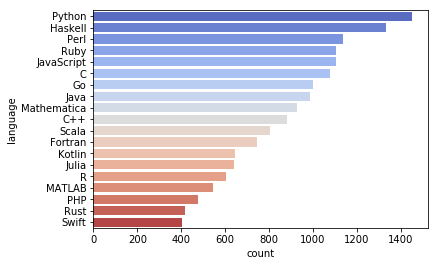

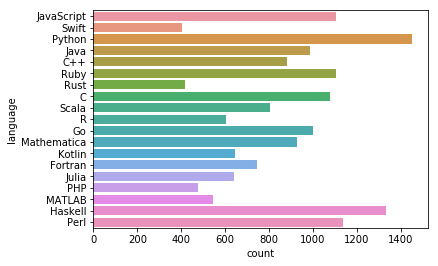

In [7]:
counts = df0.language.value_counts()
print(counts)
chart1 = plt.subplots()
sns.countplot(y = 'language', data = df0, order = counts.index, palette = "coolwarm")
chart2 = plt.subplots()
sns.countplot(y = 'language', data = df0)

Conclusion: need to rebalance the training, validation and test sets.

In [8]:
df0['file_length'] = df0['file_body'].str.len()

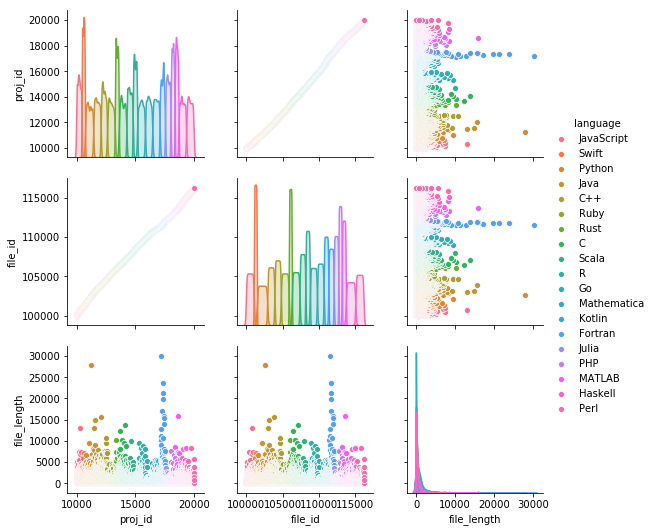

In [10]:
sns.pairplot(df0, hue = 'language') #, hue_order = counts.index)

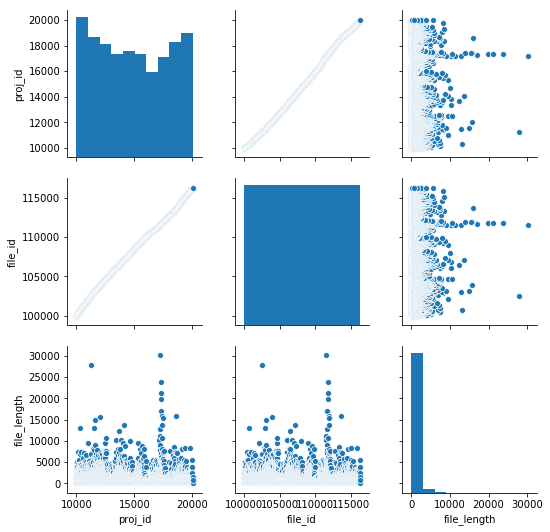

In [12]:
sns.pairplot(df0)

In [13]:
df0.describe()

,proj_id,file_id,file_length
count,16272.000000,16272.000000,16268.000000
mean,14865.454523,108136.500000,697.007438
std,3028.861049,4697.466125,1116.879086
min,10001.000000,100001.000000,2.000000
25%,12163.000000,104068.750000,129.000000
50%,14757.500000,108136.500000,346.000000
75%,17615.250000,112204.250000,831.000000
max,20009.000000,116272.000000,30106.000000


In [14]:
df0[df0.file_length.isna()]

,language,proj_id,file_id,file_body,file_length
1163,Swift,10518,101164,NaN,NaN
9951,Mathematica,15938,109952,NaN,NaN
12227,Julia,17632,112228,NaN,NaN
15290,Perl,19446,115291,NaN,NaN


Conclusion: remove NaNs.

In [15]:
for x in ['proj_id', 'file_id']:
    print(df0[x].value_counts())

17404    41
19276    19
10888    15
11364    14
11158    14
18932    14
18255    13
11390    12
10983    12
10541    12
10769    12
10066    12
10453    12
12796    12
19927    11
18778    11
14920    11
13786    11
12948    10
15603    10
10996    10
12229    10
10167    10
19590    10
13794    10
11765    10
17223    10
18750     9
18546     9
10678     9
         ..
19997     1
11897     1
11809     1
17956     1
20005     1
13866     1
15915     1
17964     1
11825     1
13874     1
17972     1
11833     1
17980     1
13890     1
15939     1
17988     1
11849     1
15947     1
13906     1
15955     1
18004     1
13914     1
18012     1
15971     1
11881     1
15979     1
11889     1
13938     1
18036     1
12286     1
Name: proj_id, Length: 10009, dtype: int64
100351    1
103063    1
111283    1
113330    1
107185    1
109232    1
115373    1
103079    1
105126    1
101028    1
111267    1
113314    1
107169    1
109216    1
115357    1
105110    1
105142    1
101012    1
111251   

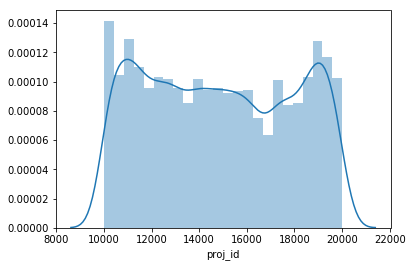

In [16]:
sns.distplot(df0.proj_id)

[Text(0, 0.5, 'counts'),
 Text(0.5, 0, 'proj_id #'),
 Text(0.5, 1.0, 'Pareto analysis - row counts vs proj_id')]

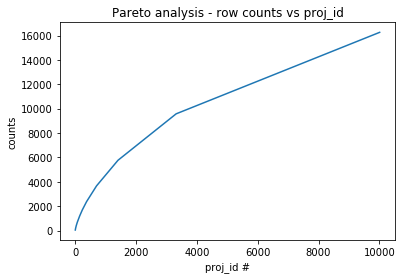

In [17]:
chart1, ax1 = plt.subplots()
sns.lineplot(data = df0['proj_id'].value_counts().cumsum().reset_index(drop = True))
ax1.set(title = 'Pareto analysis - row counts vs proj_id', xlabel = 'proj_id #', ylabel = 'counts')

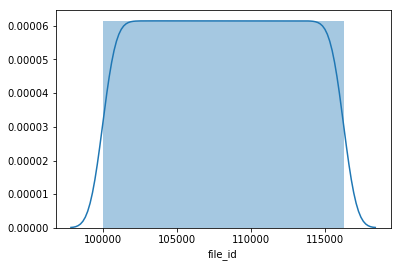

In [18]:
sns.distplot(df0.file_id)

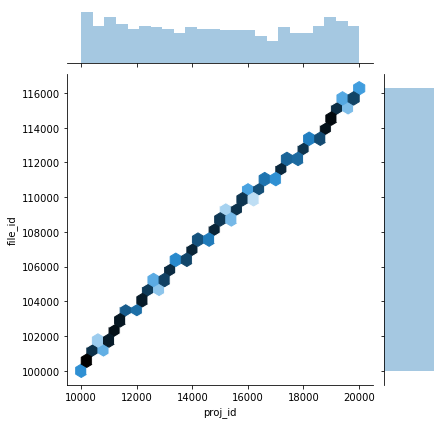

In [19]:
sns.jointplot(x = 'proj_id', y = 'file_id', kind = 'hex', data = df0)

[Text(0, 0.5, 'file lengths combined'),
 Text(0.5, 0, 'file_id #'),
 Text(0.5, 1.0, 'Pareto analysis - file lengths vs file_id')]

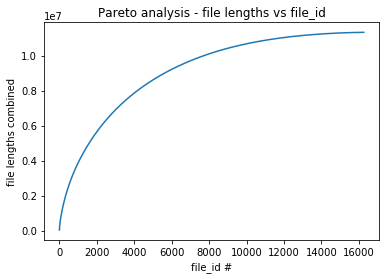

In [20]:
chart1, ax1 = plt.subplots()
sns.lineplot(data = df0['file_length'].sort_values(ascending = False).cumsum().reset_index(drop = True))
ax1.set(title = 'Pareto analysis - file lengths vs file_id', xlabel = 'file_id #', ylabel = 'file lengths combined')

AUC: 0.7828202390629555


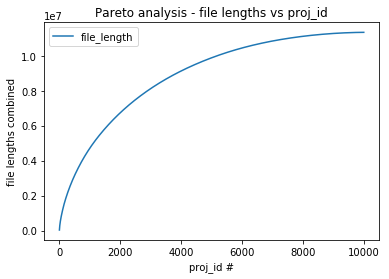

In [21]:
lengths = df0[['proj_id', 'file_length']].groupby('proj_id').agg(sum).sort_values(by = 'file_length', ascending = False).cumsum().reset_index(drop = True)
chart1, ax1 = plt.subplots()
sns.lineplot(data = lengths)
ax1.set(title = 'Pareto analysis - file lengths vs proj_id', xlabel = 'proj_id #', ylabel = 'file lengths combined')
print('AUC: {}'.format(metrics.auc(lengths.index, lengths) / (len(lengths) * max(lengths['file_length']))))
# print('AUC: {}'.format(sum(lengths.file_length) / (len(lengths) * max(lengths.file_length))))

Conclusion: need to account for file body length differences while preparing the training, validation and test sets.

**Data sets preparation**

Split the data

In [22]:
df1 = df0.dropna(axis = 0, how = 'any') # .drop_duplicates(subset = ['language', 'file_body'], keep = 'first')
df1.shape

(16268, 5)

In [23]:
df2 = df1[['language', 'proj_id', 'file_length']].groupby(['language', 'proj_id']).agg([min, max]).reset_index(drop = False)
df2.columns = [''.join(col).strip() for col in df2.columns.values]
df2.shape

(10006, 4)

In [24]:
df2.head()

,language,proj_id,file_lengthmin,file_lengthmax
0,C,13624,200.0,1525.0
1,C,13625,57.0,1803.0
2,C,13626,2294.0,2294.0
3,C,13627,766.0,1902.0
4,C,13628,2955.0,2955.0


In [25]:
for x in df2['language'].unique():
    v0 = df2['language'] == x
    df2.loc[v0, 'quantile_min'] = pd.qcut(df2.loc[v0, 'file_lengthmin'], QUANTILES)
    df2.loc[v0, 'quantile_max'] = pd.qcut(df2.loc[v0, 'file_lengthmax'], QUANTILES)

In [26]:
df2.head()

,language,proj_id,file_lengthmin,file_lengthmax,quantile_min,quantile_max
0,C,13624,200.0,1525.0,"(6.999, 257.0]","(927.0, 1695.5]"
1,C,13625,57.0,1803.0,"(6.999, 257.0]","(1695.5, 13700.0]"
2,C,13626,2294.0,2294.0,"(1299.5, 13700.0]","(1695.5, 13700.0]"
3,C,13627,766.0,1902.0,"(608.0, 1299.5]","(1695.5, 13700.0]"
4,C,13628,2955.0,2955.0,"(1299.5, 13700.0]","(1695.5, 13700.0]"


In [27]:
df2.tail()

,language,proj_id,file_lengthmin,file_lengthmax,quantile_min,quantile_max
10001,Swift,10745,125.0,125.0,"(9.999, 125.5]","(23.999, 166.0]"
10002,Swift,10746,2581.0,4558.0,"(678.5, 5878.0]","(804.5, 7067.0]"
10003,Swift,10747,808.0,808.0,"(678.5, 5878.0]","(804.5, 7067.0]"
10004,Swift,10748,571.0,809.0,"(302.0, 678.5]","(804.5, 7067.0]"
10005,Swift,10749,3669.0,3669.0,"(678.5, 5878.0]","(804.5, 7067.0]"


In [28]:
data_d = {}
data_d['training_df'], df2 = train_test_split(df2, 
                                         train_size = TRAINING_SHARE,
                                         stratify = df2[['language', 'quantile_max']], 
                                         random_state = SEED)

In [29]:
data_d['validation_df'], data_d['test_df'] = train_test_split(df2, 
                                                              train_size = VALIDATION_SHARE / (1 - TRAINING_SHARE), 
                                                              stratify = df2[['language', 'quantile_max']], 
                                                              random_state = SEED)

In [30]:
for x in data_d:
    print(x, data_d[x].shape)

training_df (6003, 6)
validation_df (2001, 6)
test_df (2002, 6)


In [31]:
for x in data_d:
    data_d[x] = pd.DataFrame(data_d[x]['proj_id']).merge(df1, on = 'proj_id', how = 'inner', validate = '1:m')
    print(x, data_d[x].shape)

training_df (9700, 5)
validation_df (3328, 5)
test_df (3240, 5)


Rebalance the data sets by language

In [32]:
ros = RandomOverSampler(sampling_strategy = 'not majority', random_state = SEED)

In [33]:
for x in data_d:
    data_d[x].reset_index(drop = True, inplace = True)
    temp_index, _ = ros.fit_resample(data_d[x].index.to_numpy().reshape(-1, 1), data_d[x]['language'])
    temp_index = shuffle(temp_index, random_state = SEED)
    data_d[x] = pd.DataFrame(temp_index).set_index(0).merge(data_d[x], how = 'left', left_index = True, right_index = True, validate = 'm:1')
    print(x, data_d[x].shape)

training_df (16093, 5)
validation_df (5928, 5)
test_df (5567, 5)


In [34]:
for x in data_d:
    print(x, data_d[x]['language'].value_counts())

training_df Go             847
Python         847
Ruby           847
PHP            847
Java           847
Julia          847
C              847
R              847
Perl           847
Haskell        847
Rust           847
Scala          847
Kotlin         847
Swift          847
Mathematica    847
MATLAB         847
Fortran        847
C++            847
JavaScript     847
Name: language, dtype: int64
validation_df C++            312
Julia          312
Perl           312
Python         312
Haskell        312
Scala          312
Ruby           312
PHP            312
Java           312
Kotlin         312
R              312
Swift          312
Mathematica    312
MATLAB         312
Fortran        312
C              312
Rust           312
Go             312
JavaScript     312
Name: language, dtype: int64
test_df C++            293
Julia          293
Perl           293
Python         293
Haskell        293
Scala          293
Ruby           293
PHP            293
Java           293
Kotlin         

Process the file bodies

In [37]:
def basic_data_prep(input_df, target_column, text_column):
    output_df = input_df[[target_column, text_column]].dropna(axis = 0, how = 'any')
    output_df[text_column] = output_df[text_column].str.replace('\s', ' ', regex = True) \
        .str.replace('(\d+\.\d+)|(\d+)', 'number', regex = True) \
        .str.replace('(\d+)', 'number', regex = True) \
        .replace({r'(^[^a-zA-Z_]+)([a-zA-Z_]+)' : r'\1 \2'}, regex=True) \
        .replace({r'([a-zA-Z_]+)' : r' \1 '}, regex=True) \
        .str.replace('\s+', ' ', regex = True) \
        .str.strip()
    output_df[text_column] = output_df[text_column].apply(lambda x: x.split(' '))
    return output_df

In [38]:
processed_data_d = {}
for x in data_d:
    processed_data_d[x] = basic_data_prep(data_d[x], 'language', 'file_body')
    print(x, processed_data_d[x].shape)
    processed_data_d[x]['sequence_length'] = processed_data_d[x]['file_body'].apply(lambda x: len(set(x)))
    print(processed_data_d[x]['sequence_length'].describe())    

training_df (16093, 2)
count    16093.000000
mean        52.007954
std         55.561511
min          1.000000
25%         19.000000
50%         38.000000
75%         67.000000
max       1125.000000
Name: sequence_length, dtype: float64
validation_df (5928, 2)
count    5928.000000
mean       52.334852
std        54.818033
min         1.000000
25%        19.000000
50%        37.000000
75%        67.000000
max      1654.000000
Name: sequence_length, dtype: float64
test_df (5567, 2)
count    5567.000000
mean       53.175858
std        61.083316
min         1.000000
25%        18.000000
50%        37.000000
75%        68.000000
max      1108.000000
Name: sequence_length, dtype: float64


##Simple benchmark model

In [39]:
vectorizer = CountVectorizer(lowercase = False, max_df = 0.7, min_df = 2, binary = True, ngram_range = (1, 2))
#vectorizer.fit(data_d['training_df']['file_body'].drop_duplicates())
vectorizer.fit(processed_data_d['training_df']['file_body'].map(' '.join).drop_duplicates())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=0.7, max_features=None, min_df=2,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [40]:
vectorizer.get_feature_names()

['AALGA',
 'AALGA YDNMP',
 'AB',
 'AB Anders',
 'AB BD',
 'AB CD',
 'AB Janssen',
 'AB de',
 'ABC',
 'ABC ABC',
 'ABC DEF',
 'ABC FGHI',
 'ABC number',
 'ABC qw',
 'ABCD',
 'ABCD CABD',
 'ABCD permutations',
 'ABCDEF',
 'ABCDEF number',
 'ABCDEFGHIJKL',
 'ABCDEFGHIJKL NOPQRSTUVWXYZ',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ abcdefghijklmnopqrstuvwxyz',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyznumber',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyznumber number',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyznumber numberedfnumberanumberbenumbercnumberacnumberdanumberenumberbnumbera',
 'ABCDEFGHIJKLMNOPQSTUVWXYZ',
 'ABDC',
 'ABDC ADBC',
 'ABJURER',
 'ABOVE',
 'ABS',
 'ACBD',
 'ACBD ADCB',
 'ACCESS',
 'ACCESS DIRECT',
 'ACDB',
 'ACDB DACB',
 'ACHAR',
 'ACHAR number',
 'ACM',
 'ACM Vol',
 'ACOS',
 'ACTION',
 'ACTION READ',
 'ACTION WRITE',
 'AD',
 'AD as',
 'AD number',
 'AD positive',
 'ADBC',
 'ADBC BDCA',
 'ADCB',
 'ADCB CDAB',
 'ADJACENT

In [41]:
#X_train = vectorizer.transform(data_d['training_df']['file_body'])
X_train = vectorizer.transform(processed_data_d['training_df']['file_body'].map(' '.join))
X_train

<16093x74630 sparse matrix of type '<class 'numpy.int64'>'
	with 934484 stored elements in Compressed Sparse Row format>

In [42]:
#X_test = vectorizer.transform(data_d['test_df']['file_body'])
X_test = vectorizer.transform(processed_data_d['test_df']['file_body'].map(' '.join))
X_test

<5567x74630 sparse matrix of type '<class 'numpy.int64'>'
	with 283191 stored elements in Compressed Sparse Row format>

In [43]:
benchmark_classifier = LogisticRegression(solver = 'liblinear', multi_class = 'ovr') #, n_jobs = -1)
benchmark_classifier.fit(X_train, data_d['training_df']['language'])
benchmark_score = benchmark_classifier.score(X_test, data_d['test_df']['language'])
print('Accuracy:', benchmark_score)

Accuracy: 0.8577330698760554


In [44]:
y_test_predicted = benchmark_classifier.predict(X_test)

In [45]:
metrics.accuracy_score(data_d['test_df']['language'], y_test_predicted)

0.8577330698760554

In [46]:
print('F1 - macro average:', metrics.f1_score(data_d['test_df']['language'], y_test_predicted, average = 'macro'))
print('F1 - micro average:', metrics.f1_score(data_d['test_df']['language'], y_test_predicted, average = 'micro'))
print('F1 by label:', pd.DataFrame({'labels': sorted(data_d['test_df']['language'].unique()), 'scores': metrics.f1_score(data_d['test_df']['language'], y_test_predicted, average = None)}), sep = '\n')

F1 - macro average: 0.8636192203910025
F1 - micro average: 0.8577330698760554
F1 by label:
         labels    scores
0             C  0.891156
1           C++  0.918728
2       Fortran  0.930728
3            Go  0.950877
4       Haskell  0.872154
5          Java  0.939716
6    JavaScript  0.755556
7         Julia  0.868794
8        Kotlin  0.987910
9        MATLAB  0.739823
10  Mathematica  0.641723
11          PHP  0.880435
12         Perl  0.840000
13       Python  0.874786
14            R  0.721915
15         Ruby  0.893471
16         Rust  0.881679
17        Scala  0.941176
18        Swift  0.878136


In [47]:
benchmark_confusion_matrix = pd.DataFrame(metrics.confusion_matrix(data_d['test_df']['language'], y_test_predicted, labels = sorted(data_d['test_df']['language'].unique())))
benchmark_confusion_matrix.index = benchmark_confusion_matrix.columns = sorted(data_d['test_df']['language'].unique())
benchmark_confusion_matrix # rows = true, cols = predicted

,C,C++,Fortran,Go,Haskell,Java,JavaScript,Julia,Kotlin,MATLAB,Mathematica,PHP,Perl,Python,R,Ruby,Rust,Scala,Swift
C,262,2,1,0,0,1,3,0,0,2,13,3,0,2,2,0,0,2,0
C++,13,260,3,0,0,0,1,3,0,0,10,2,0,0,1,0,0,0,0
Fortran,0,0,262,0,1,0,1,0,0,3,25,0,0,1,0,0,0,0,0
Go,5,0,0,271,3,0,3,0,0,0,7,1,0,2,0,0,0,1,0
Haskell,1,2,1,0,249,2,4,1,0,1,30,0,0,1,1,0,0,0,0
Java,3,0,0,0,1,265,9,0,0,0,5,0,2,0,4,0,0,3,1
JavaScript,0,1,0,0,1,2,221,0,0,9,38,3,4,2,6,4,0,0,2
Julia,0,0,0,0,5,1,0,245,0,15,18,0,3,0,4,2,0,0,0
Kotlin,0,0,0,0,0,0,0,0,286,0,3,0,0,1,0,0,0,3,0
MATLAB,0,0,2,0,6,0,6,3,0,209,42,0,0,8,15,2,0,0,0


##Complex model - RNN

**Prepare the word embeddings**

In [48]:
### Prepare the FastText model:
s0 = processed_data_d['training_df']['file_body']
print(len(s0))
s0 = s0.loc[~s0.index.duplicated(keep = 'first')]
print(len(s0))

WE_model_FastText_skipgram = gensim.models.FastText(size = WORD_EMBEDDING_SIZE, seed = SEED, window = 3, min_count = 2, workers = 7, sg = 1, word_ngrams = 1)
WE_model_FastText_skipgram.build_vocab(s0)
WE_model_FastText_skipgram.train(s0, total_examples = WE_model_FastText_skipgram.corpus_count, epochs = 10)
print('Number of FastText vectors:', len(WE_model_FastText_skipgram.wv.index2entity))

16093
9700
Number of FastText vectors: 41752


In [49]:
### Prepare the token index:
def create_word2index(sequences_array):
    tokens_set = set()

    for x in sequences_array:
        for token in x:
            tokens_set.add(token)
    print('Number of distinct tokens:', len(tokens_set))

    word2index = {t: i + 2 for i, t in enumerate(sorted(tokens_set))} # i + 2 if -OOV-, i + 1 otherwise
    word2index['-PAD-'] = 0  # The special value used for padding
    word2index['-OOV-'] = 1  # The special value used for OOVs (out-of-vocabulary tokens).
    return word2index

word2index = create_word2index(s0)

Number of distinct tokens: 96187


In [50]:
### Prepare the word embedding matrix:
def create_word_embedding_matrix(word2index, word_vectors, embedding_size, index_start = 0): # See below re index_start.
    # word_vectors needs to be dictionary-like, e.g. Gensim keyed vectors - https://radimrehurek.com/gensim/models/keyedvectors.html
    print('Filling the embeddings...')
    num_words = len(word2index) + index_start # If using tensorflow.keras.preprocessing.text.Tokenizer , use len(word2index) + 1 as the Keras's word index starts from 1.
    embedding_matrix = np.zeros((num_words, embedding_size))
    for token, i in word2index.items():
        try:
            embedding_vector = word_vectors.get_vector(token) # Not word2vec[word], as NAs would throw exceptions.
            # Words not found in the pre-trained embedding index will remain all zeros.
            embedding_matrix[i] = embedding_vector
        except:
            pass
    return embedding_matrix, num_words

wv = WE_model_FastText_skipgram.wv
embedding_matrix, num_words = create_word_embedding_matrix(word2index, wv, WORD_EMBEDDING_SIZE, index_start = 0)
embedding_matrix.shape

Filling the embeddings...


(96189, 128)

In [51]:
### Prepare the label index:
def create_label2index(labels_array):
    labels_set = set()
    for x in labels_array:
        labels_set.add(x)
    print('Number of classes:', len(labels_set))

    label2index = {l: i for i, l in enumerate(sorted(labels_set))}    
    return label2index

label2index = create_label2index(data_d['test_df']['language'].unique())
label2index

Number of classes: 19


{'C': 0,
 'C++': 1,
 'Fortran': 2,
 'Go': 3,
 'Haskell': 4,
 'Java': 5,
 'JavaScript': 6,
 'Julia': 7,
 'Kotlin': 8,
 'MATLAB': 9,
 'Mathematica': 10,
 'PHP': 11,
 'Perl': 12,
 'Python': 13,
 'R': 14,
 'Ruby': 15,
 'Rust': 16,
 'Scala': 17,
 'Swift': 18}

**Prepare the data**

In [52]:
def tokens2numbers(sequences_array, word2index = {}, OoV = '-OOV-'):
    sequences_X = []
    for x in sequences_array:
        sequence_int = []
        for token in x:
            try:
                sequence_int.append(word2index[token])
            except KeyError:
                sequence_int.append(word2index[OoV])
        sequences_X.append(sequence_int)
    return sequences_X


def prepare_training_data(max_sequence_length, training_sequences_data_array, training_sequences_labels_array, word2index, label2index):
    import tensorflow as tf

    ### Convert texts into numbers:
    sequences_X = tokens2numbers(training_sequences_data_array, word2index = word2index, OoV = '-OOV-')

    labels_y = []
    for x in training_sequences_labels_array:
        labels_y.append([label2index[x]])

    ### Pad sequences:
    data_X = tf.keras.preprocessing.sequence.pad_sequences(sequences_X, maxlen = max_sequence_length, padding = 'post')
    print('Shape of sequence data tensor:', data_X.shape)

    ### One-hot encoding of labels (as this is what the Dense layer will output later on):
    cat_data_y = tf.keras.utils.to_categorical(labels_y, len(label2index))
    print('Shape of one-hot encoded labels data tensor:', cat_data_y.shape)

    return data_X, cat_data_y


X_tensors_d = {}
Y_tensors_d = {}
for x in processed_data_d:
    print(x)
    X_tensors_d[x], Y_tensors_d[x] = prepare_training_data(MAX_SEQUENCE_LENGTH, processed_data_d[x]['file_body'], processed_data_d[x]['language'], word2index, label2index)

training_df
Shape of sequence data tensor: (16093, 128)
Shape of one-hot encoded labels data tensor: (16093, 19)
validation_df
Shape of sequence data tensor: (5928, 128)
Shape of one-hot encoded labels data tensor: (5928, 19)
test_df
Shape of sequence data tensor: (5567, 128)
Shape of one-hot encoded labels data tensor: (5567, 19)


**Prepare the model**

In [53]:
def create_model(max_sequence_length = MAX_SEQUENCE_LENGTH, num_words = num_words, embedding_size = WORD_EMBEDDING_SIZE, embedding_matrix = embedding_matrix, labels_n = len(label2index),
                 extra_recurrent_layers_n = 1, recurrent_layer_type = LSTM, recurrent_layer_units = 256,
                 optimizer = tf.keras.optimizers.Adam, learning_rate = LEARNING_RATE,
                 metrics = ['accuracy']):
    ### Neural network architecture:
    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.InputLayer(input_shape=(max_sequence_length, )))
    model.add(tf.keras.layers.Embedding(
            num_words,
            embedding_size,
            weights = [embedding_matrix],
            input_length = max_sequence_length,
            trainable = False
            ))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    for layer in range(extra_recurrent_layers_n):
        model.add(tf.keras.layers.Bidirectional(recurrent_layer_type(recurrent_layer_units, return_sequences = True)))
    model.add(tf.keras.layers.Bidirectional(recurrent_layer_type(recurrent_layer_units, return_sequences = False))) # dropout = 0.2, recurrent_dropout = 0.2
    model.add(tf.keras.layers.Dropout(0.2))
    #model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(labels_n)))
    model.add(tf.keras.layers.Dense(labels_n, activation = 'softmax'))
    #model.add(tf.keras.layers.Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer(lr = learning_rate),
                  metrics = metrics)

    model.summary()
    return model

model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 128)          12312192  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 512)          790528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1576960   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 19)                9747      
Total params: 14,689,427
Trainable params: 2,377,235
Non-trainable params: 12,312,192
________________________________________________________

In [59]:
print('Training the model...')
history = model.fit(
        X_tensors_d['training_df'],
        Y_tensors_d['training_df'],
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (X_tensors_d['validation_df'], Y_tensors_d['validation_df']),
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.001)]
        )

Training the model...
Train on 16093 samples, validate on 5928 samples
Epoch 1/8
16093/16093 [==============================] - 14s 885us/step - loss: 0.1092 - acc: 0.9663 - val_loss: 0.4948 - val_acc: 0.8743
Epoch 2/8
16093/16093 [==============================] - 14s 886us/step - loss: 0.1071 - acc: 0.9672 - val_loss: 0.4807 - val_acc: 0.8812
Epoch 3/8
16093/16093 [==============================] - 14s 892us/step - loss: 0.0924 - acc: 0.9724 - val_loss: 0.5009 - val_acc: 0.8812
Epoch 4/8
16093/16093 [==============================] - 14s 878us/step - loss: 0.0745 - acc: 0.9773 - val_loss: 0.5286 - val_acc: 0.8769
Epoch 5/8
16093/16093 [==============================] - 14s 886us/step - loss: 0.0795 - acc: 0.9746 - val_loss: 0.4709 - val_acc: 0.8841
Epoch 6/8
16093/16093 [==============================] - 14s 888us/step - loss: 0.0622 - acc: 0.9814 - val_loss: 0.5192 - val_acc: 0.8817
Epoch 7/8
16093/16093 [==============================] - 14s 891us/step - loss: 0.0539 - acc: 0.9835 

In [60]:
y_test_predicted_RNN = np.argmax(model.predict(X_tensors_d['test_df']), axis = 1)
y_test_true = np.argmax(Y_tensors_d['test_df'], axis = 1)

In [61]:
print('Test set accuracy:', sum(y_test_predicted_RNN == y_test_true) / len(y_test_true))

Test set accuracy: 0.8814442248967128


In [62]:
print('F1 - macro average:', metrics.f1_score(y_test_true, y_test_predicted_RNN, average = 'macro'))
print('F1 - micro average:', metrics.f1_score(y_test_true, y_test_predicted_RNN, average = 'micro'))
print('F1 by label:', pd.DataFrame({'labels': sorted(data_d['test_df']['language'].unique()), 'scores': metrics.f1_score(y_test_true, y_test_predicted_RNN, average = None)}), sep = '\n')

F1 - macro average: 0.8820756785602607
F1 - micro average: 0.8814442248967128
F1 by label:
         labels    scores
0             C  0.801325
1           C++  0.900000
2       Fortran  0.938053
3            Go  0.939759
4       Haskell  0.925734
5          Java  0.878689
6    JavaScript  0.837456
7         Julia  0.848080
8        Kotlin  0.948673
9        MATLAB  0.840678
10  Mathematica  0.882759
11          PHP  0.866667
12         Perl  0.888525
13       Python  0.851675
14            R  0.854671
15         Ruby  0.878594
16         Rust  0.925859
17        Scala  0.899351
18        Swift  0.852893


In [63]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_true, y_test_predicted_RNN))
confusion_matrix.index = confusion_matrix.columns = sorted(data_d['test_df']['language'].unique())
confusion_matrix # rows = true, cols = predicted

,C,C++,Fortran,Go,Haskell,Java,JavaScript,Julia,Kotlin,MATLAB,Mathematica,PHP,Perl,Python,R,Ruby,Rust,Scala,Swift
C,242,1,1,2,1,24,2,0,0,2,5,2,3,3,3,1,0,1,0
C++,24,243,1,0,0,11,1,0,0,3,6,0,0,1,0,1,2,0,0
Fortran,1,0,265,0,1,4,0,2,0,13,0,0,0,4,2,1,0,0,0
Go,1,0,0,273,3,0,2,0,0,2,0,0,0,1,0,0,0,1,10
Haskell,2,0,1,1,268,0,0,3,0,2,5,0,2,2,4,3,0,0,0
Java,8,0,0,0,0,268,6,0,0,0,0,5,0,1,2,0,0,1,2
JavaScript,5,0,1,3,0,6,237,1,0,2,4,0,3,2,4,3,0,7,15
Julia,1,0,0,6,6,0,0,254,0,6,0,0,1,3,3,10,0,2,1
Kotlin,1,0,0,3,0,0,0,0,268,0,0,0,0,0,0,0,0,18,3
MATLAB,8,0,3,0,2,0,3,6,0,248,2,2,2,4,3,10,0,0,0


Conclusion: not a great improvement over the benchmark model.

**To do/try**

- Improved splitting of data into train / validation / test sets
- Not rebalancing the data
- Improved parser (see 'Parsing Formal Languages using Natural Language Parsing Techniques' at https://www.aclweb.org/anthology/W09-3807)
- Try GRU instead of LSTM
- 2nd simple benchmark model with a custom vectorizer that keeps non-words
- Random search for optimal hyperparameters
- Data augmentation
- Topic modelling with LDA
- k-means clustering on word embeddings - as basis for an alternative simple model
- Logging (important especially outside of Jupyter)